This notebook reproduces some of the reulsts obtained in the following paper for calibrating neural networks https://arxiv.org/pdf/1706.04599.pdf

For a perfectly calibrated neural network we expect that the confidence should match the accuracy. For example, if we have a 100 examples and we classify each of them with 80% confidence, then the accuracy of predictions should be ~80%

$P(\hat{y} = y | \hat{p} = p ) = p$, where $p$ is the confidence. 


In [1]:
import os
import sys
from datetime import datetime

import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


In [2]:
"""
Collect data
"""

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train / 255.
x_test = x_test / 255.

one_hot_y_train = keras.utils.to_categorical(y_train, 10)
one_hot_y_test = keras.utils.to_categorical(y_test, 10)

print(x_train.shape, one_hot_y_train.shape, x_test.shape, one_hot_y_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [3]:
# define a sequential Lenet model
lenet = keras.Sequential()
lenet.add(keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32,32,3), padding='same'))
lenet.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
lenet.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
lenet.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
lenet.add(keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
lenet.add(keras.layers.Flatten())
lenet.add(keras.layers.Dense(84, activation='tanh'))
lenet.add(keras.layers.Dense(10))
lenet.add(keras.layers.Activation('softmax'))
lenet.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])
print(lenet.summary())







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 6)         456       
_________________________________________________________________
average_pooling2d_1 (Average (None, 31, 31, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 120)         48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 9720)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 84)         

In [5]:
lenet.fit(x_train, one_hot_y_train, batch_size=32, epochs=10)



Epoch 1/10
50000/50000 [==============================] - 16s 312us/step - loss: 1.0521 - acc: 0.6298
Epoch 2/10
50000/50000 [==============================] - 15s 308us/step - loss: 1.0176 - acc: 0.6440
Epoch 3/10
50000/50000 [==============================] - 16s 310us/step - loss: 0.9810 - acc: 0.6579
Epoch 4/10
50000/50000 [==============================] - 15s 310us/step - loss: 0.9506 - acc: 0.6697
Epoch 5/10
50000/50000 [==============================] - 15s 310us/step - loss: 0.9165 - acc: 0.6836
Epoch 6/10
50000/50000 [==============================] - 16s 312us/step - loss: 0.8851 - acc: 0.6932
Epoch 7/10
50000/50000 [==============================] - 16s 314us/step - loss: 0.8530 - acc: 0.7065
Epoch 8/10
50000/50000 [==============================] - 16s 311us/step - loss: 0.8214 - acc: 0.7174
Epoch 9/10
50000/50000 [==============================] - 16s 314us/step - loss: 0.7896 - acc: 0.7275
Epoch 10/10
50000/50000 [==============================] - 16s 313us/step - loss: 

In [6]:
lenet_predictions = lenet.predict(x_test)
lenet_score = lenet.evaluate(x_test, one_hot_y_test)
print(lenet_score)

10000/10000 [==============================] - 1s 126us/step
[1.2220160154342652, 0.5907]


In [7]:
lenet_predictions.shape

(10000, 10)

In [8]:
# Create a dataframe with the predictions and the ground truth values
df = pd.DataFrame()
class_prediction = np.argmax(lenet_predictions, axis=1)
class_confidence = np.max(lenet_predictions, axis=1)
print("Min-max confidence: ", np.min(class_confidence), np.max(class_confidence))
df['predictions'] = class_prediction
df['gt'] = y_test
df['scores'] = class_confidence
df['correct'] = df['gt'] == df['predictions']
df.head()

Min-max confidence:  0.19107568 0.9998115


,predictions,gt,scores,correct
0,3,3,0.707687,True
1,1,8,0.488621,False
2,1,8,0.814998,False
3,0,0,0.958441,True
4,3,6,0.431724,False


In [23]:
i = 0.1
min_conf = i
max_conf = i+0.1
temp_df = df.loc[(df.scores >= min_conf) & (df.scores < max_conf)]
fc, tc = temp_df.correct.value_counts().sort_index().tolist()
print(df.correct.value_counts())
print(fc, tc)
print(tc / (tc + fc))
print(len(temp_df))

ValueError: ignored

In [37]:
temp_df.correct.value_counts().index[0]

False

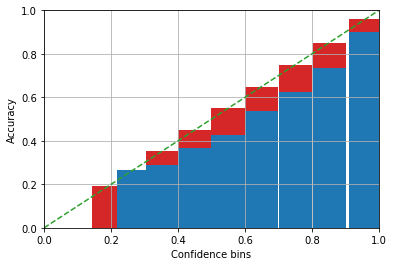

In [39]:
ret = plot_miscalibration(df)

In [34]:
a = temp_df.correct.value_counts()
a.index[0]

False

In [0]:

def plot_miscalibration(df):
    bins = np.linspace(0,1,11)[:-1]
    ret = []
    for i in bins:
        min_conf = i
        max_conf = i+0.1
        temp_df = df.loc[(df.scores >= min_conf) & (df.scores < max_conf)]
        n_samples = len(temp_df)
        if n_samples > 0:
            bin_conf = temp_df.scores.mean()
            if temp_df.correct.nunique() > 1:
                fc, tc = temp_df.correct.value_counts().sort_index().tolist()
            elif temp_df.correct.value_counts().index[0]:
                tc = temp_df.correct.value_counts().sort_index().tolist()
            else:
                tc = 0
            bin_acc = tc / n_samples
        else:
            bin_conf = 0
            bin_acc = 0
        bin_error = np.abs(bin_conf - bin_acc)
        weighted_bin_error = n_samples * bin_error
        ret.append([bin_conf, bin_acc, bin_error, weighted_bin_error, n_samples])
    ret =  np.array(ret)
    plt.bar(ret[:,0], ret[:,1] + ret[:,2], width=0.1, color='C3')
    plt.bar(ret[:,0], ret[:,1], width=0.1, color='C0')
    plt.plot([0,1],'--C2')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('Confidence bins')
    plt.ylabel('Accuracy')
    plt.grid()
    return ret

In [45]:
logits = lenet.layers[-2].output
new_model = keras.Model(inputs=lenet.input, outputs=logits)
logits_pred = new_model.predict(x_test)

(10000, 10)


In [54]:
print(logits_pred.shape, one_hot_y_test.shape)
t = TemperatureScaling()
t.fit(logits_pred, one_hot_y_test)
calib_out = t.predict(logits_pred)


(10000, 10) (10000, 10)


In [56]:
df = pd.DataFrame()
class_prediction = np.argmax(calib_out, axis=1)
class_confidence = np.max(calib_out, axis=1)
print("Min-max confidence: ", np.min(class_confidence), np.max(class_confidence))
df['predictions'] = class_prediction
df['gt'] = y_test
df['scores'] = class_confidence
df['correct'] = df['gt'] == df['predictions']
df.head()

Min-max confidence:  0.16658059 0.99726176


,predictions,gt,scores,correct
0,3,3,0.555484,True
1,1,8,0.443187,False
2,1,8,0.720760,False
3,0,0,0.880043,True
4,3,6,0.375117,False


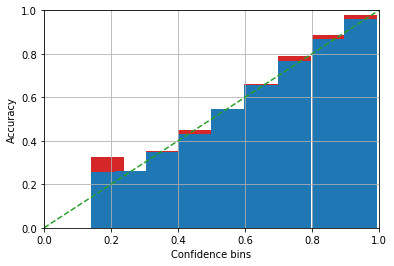

In [57]:
ret = plot_miscalibration(df)

In [0]:
from scipy.optimize import minimize 
from sklearn.metrics import log_loss
import pandas as pd
import time
from sklearn.metrics import log_loss, brier_score_loss
from keras.losses import categorical_crossentropy
from os.path import join
import sklearn.metrics as metrics

def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    
    Parameters:
        x (numpy.ndarray): array containing m samples with n-dimensions (m,n)
    Returns:
        x_softmax (numpy.ndarray) softmaxed values for initial (m,n) array
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=1)

class TemperatureScaling():
    
    def __init__(self, temp = 1, maxiter = 50, solver = "BFGS"):
        """
        Initialize class
        
        Params:
            temp (float): starting temperature, default 1
            maxiter (int): maximum iterations done by optimizer, however 8 iterations have been maximum.
        """
        self.temp = temp
        self.maxiter = maxiter
        self.solver = solver
    
    def _loss_fun(self, x, probs, true):
        # Calculates the loss using log-loss (cross-entropy loss)
        scaled_probs = self.predict(probs, x)    
        loss = log_loss(y_true=true, y_pred=scaled_probs)
        return loss
    
    # Find the temperature
    def fit(self, logits, true):
        """
        Trains the model and finds optimal temperature
        
        Params:
            logits: the output from neural network for each class (shape [samples, classes])
            true: one-hot-encoding of true labels.
            
        Returns:
            the results of optimizer after minimizing is finished.
        """
        
        # true = true.flatten() # Flatten y_val
        opt = minimize(self._loss_fun, x0 = 1, args=(logits, true), options={'maxiter':self.maxiter}, method = self.solver)
        self.temp = opt.x[0]
        
        return opt
        
    def predict(self, logits, temp = None):
        """
        Scales logits based on the temperature and returns calibrated probabilities
        
        Params:
            logits: logits values of data (output from neural network) for each class (shape [samples, classes])
            temp: if not set use temperatures find by model or previously set.
            
        Returns:
            calibrated probabilities (nd.array with shape [samples, classes])
        """
        
        if not temp:
            return softmax(logits/self.temp)
        else:
            return softmax(logits/temp)
            

Min-max confidence:  0.26938424 1.0
0.27895716 0.3333333333333333
0.36445746 0.13513513513513514
0.46214193 0.3474576271186441
0.54844326 0.3271276595744681
0.64787436 0.38786279683377306
0.7505153 0.3844282238442822
0.8537652 0.45151033386327505
0.99164075 0.8091214117062259
ECE:  0.028122764123180037


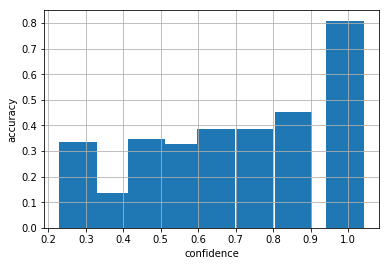

In [0]:
ECE = plot_discrepancy(lenet_predictions, y_test)
np.save('lenet_predictions', lenet_predictions)
print("ECE: ", ECE)

In [0]:
"""
Define a function that accepts predictions and ground truths, then plots the 
confidence vs. accuracy. This plot is also known as a reliability diagram.

Instead of assessing the calibration by looking at reliability diagrams, we can
use a single scalar number, which is the Expected Calibration Error ECE
"""
def plot_discrepancy(prediction, ground_truth):
    class_prediction = np.argmax(prediction, axis=1)
    class_confidence = np.max(prediction, axis=1)
    print("Min-max confidence: ", np.min(class_confidence), np.max(class_confidence))
    error = (class_prediction - ground_truth.flatten())
    indicies_sum = 0
    all_acc = []
    all_conf = []
    ECE = 0
    # create 10 bins
    for i in range(0,10):
        # indices for the min-max softmax that lies within certain range (B_m)
        min_conf = i*0.1
        max_conf = (i+1) * 0.1
        indices = np.argwhere((class_confidence >= min_conf) &(class_confidence  <= max_conf)).flatten()
        if len(indices) != 0:
            confidence_bm = class_confidence[indices]
            correct_predictions = np.argwhere(np.argwhere(error[indices] == 0))
            if len(correct_predictions) != 0:
                accuracy_bm = len(correct_predictions) / len(indices)
                all_acc.append(accuracy_bm)
                all_conf.append(np.mean(confidence_bm))
                print(np.mean(confidence_bm), accuracy_bm)
                ECE += np.abs(np.mean(confidence_bm) - accuracy_bm) / len(indices)
            
    plt.bar(all_conf, all_acc, width=0.1)
    plt.grid()
    plt.xlabel('confidence')
    plt.ylabel('accuracy')
    return ECE


In [0]:
keras.backend.clear_session()
model = keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3), classes=10)
output = model.output
pred = keras.layers.Flatten()(output)
pred = keras.layers.Dense(10, activation='softmax')(pred)

vgg = keras.models.Model(inputs=model.input, outputs=[pred])
vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = vgg.fit(x_train, one_hot_y_train, epochs=50)

In [0]:
score = vgg.evaluate(x_test, one_hot_y_test)
print(score)

10000/10000 [==============================] - 6s 582us/step
[1.0678949194908143, 0.7996]


Min-max confidence:  0.23916952 1.0
0.27656728 0.4
0.35325637 0.25316455696202533
0.45805773 0.3050847457627119
0.5479865 0.3238095238095238
0.65205085 0.3954983922829582
0.7534384 0.42650602409638555
0.85503286 0.5209923664122137
0.9923689 0.8861549761292692


0.01744938446823449

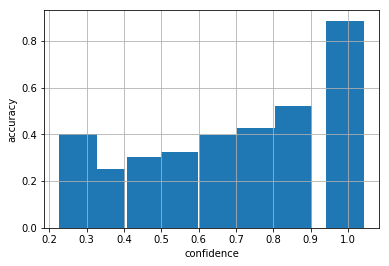

In [0]:
vgg_predictions = vgg.predict(x_test)
plot_discrepancy(vgg_predictions, y_test)

In [0]:
print("Predictions shape: ", pred.shape)
print("softmax output for first test samples: \n", pred[0])

Predictions shape:  (10000, 10)
softmax output for first test samples: 
 [2.1020765e-06 5.7894169e-05 1.5895067e-06 9.9923861e-01 1.6379404e-08
 3.1021945e-04 6.8256741e-05 1.7916864e-05 1.9540475e-06 3.0148731e-04]


In [0]:
pred_idx = np.argmax(pred, axis=1)
max_conf = np.max(pred, axis=1)
print(pred_idx.shape, max_conf.shape)
print(np.min(max_conf), np.max(max_conf))

(10000,) (10000,)
0.24877599 1.0


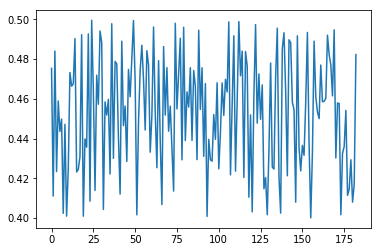

In [0]:
# check
plt.plot(max_pred[np.argwhere((max_pred > 0.4) &(max_pred  < 0.5))])

In [0]:
diff = pred_idx - y_test.flatten()
indices = np.argwhere((max_pred > (0.2)) &(max_pred  < (0.3))).flatten()
print(indices)
print(pred_idx[indices])
print(y_test.flatten()[indices])
print(diff[indices])
print(len(np.argwhere(diff[indices] == 0)))
print(len(np.argwhere(diff == 0)))

[ 366  376 1493 1736 2136 2232 2804 2840 3263 3391 3789 4190 5166 5517
 5869 6574 6729 6859 6904 6997 8006 9114]
[9 9 9 2 9 0 7 6 9 9 7 5 0 1 7 4 0 3 5 2 9 0]
[1 0 1 5 0 0 3 3 1 3 9 3 9 1 7 0 0 3 5 8 9 8]
[ 8  9  8 -3  9  0  4  3  8  6 -2  2 -9  0  0  4  0  0  0 -6  0 -8]
7
8072


In [0]:
# create 10 bins
hist = []
indicies_sum = 0
for i in range(0,10):
    print("Calculating predictions within confidence range {} - {}".format((i*0.1), ((i+1)*0.1)))
    # indices for the max softmax that lies within certain range
    indices = np.argwhere((max_pred >= (i*0.1)) &(max_pred  <= (0.1*(i+1)))).flatten()
    indicies_sum += len(indices)
    correct_predictions = np.argwhere(np.argwhere(diff[indices] == 0))
    print("Number of correct predictions for the specified confidence range", len(correct_predictions))
    hist.append(len(correct_predictions))

Calculating predictions within confidence range 0.0 - 0.1
Number of correct predictions for the specified confidence range 0
Calculating predictions within confidence range 0.1 - 0.2
Number of correct predictions for the specified confidence range 0
Calculating predictions within confidence range 0.2 - 0.30000000000000004
Number of correct predictions for the specified confidence range 7
Calculating predictions within confidence range 0.30000000000000004 - 0.4
Number of correct predictions for the specified confidence range 26
Calculating predictions within confidence range 0.4 - 0.5
Number of correct predictions for the specified confidence range 65
Calculating predictions within confidence range 0.5 - 0.6000000000000001
Number of correct predictions for the specified confidence range 98
Calculating predictions within confidence range 0.6000000000000001 - 0.7000000000000001
Number of correct predictions for the specified confidence range 140
Calculating predictions within confidence r

In [0]:
a = np.array([2,2])
b = np.array([3,0])
print(np.linalg.norm(a,2))
print(np.linalg.norm(b,2))
print(np.linalg.norm(b,2) * np.linalg.norm(a,2) * np.cos(np.deg2rad(45)))
print(np.matmul(a, b))

2.8284271247461903
3.0
6.000000000000001
6
